# Dataset Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import f1_score, log_loss, roc_auc_score, \
        roc_curve, auc, precision_recall_curve
from sklearn.linear_model import SGDClassifier

%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')


In [2]:
df=pd.read_csv('data.csv').drop(['Unnamed: 0'], 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, var_366 to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [3]:
# Train and test set... Do not touch the test set until final testing of your models
X_train, X_test, Y_train, Y_test = train_test_split(
    df.drop(labels=['TARGET'], axis=1),
    df['TARGET'], test_size=0.3,random_state=42)

X_train.shape, X_test.shape

((53214, 370), (22806, 370))

In [4]:
# import pandas_profiling
# profile = X_train.iloc[:,:-2].profile_report(title='Train set Profiling Report')
# profile.to_file(output_file="train.html")

# Analyze basic characteristics of your training Data

## Target variable

In [5]:
Y_train.value_counts()

0    51121
1     2093
Name: TARGET, dtype: int64

We can figure out that the target variable is very imbalanced. The positive label is only 4% of all samples.

 ## Characteristics of features

In [6]:
X_train.head()

,var_366,var_364,var_38,var_39,var_40,var_44,var_45,var_46,var_47,var_48,...,var_317,var_318,var_319,var_320,var_321,var_322,var_323,var_324,var_368,ID
199,2,71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,165191.58,394
62460,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110940.57,124716
32495,2,38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,89347.14,64953
46788,2,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92325.69,93556
61106,2,53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,112730.85,121970


The feature matrix is very sparse. It seems that there are many catogiral features.

In [7]:
# number of unique values for each feature
nuni_series = X_train.nunique()
# joblib.dump(nuni_series, 'nuni_series.pkl')

In [8]:
# nuni_series = joblib.load('nuni_series.pkl')

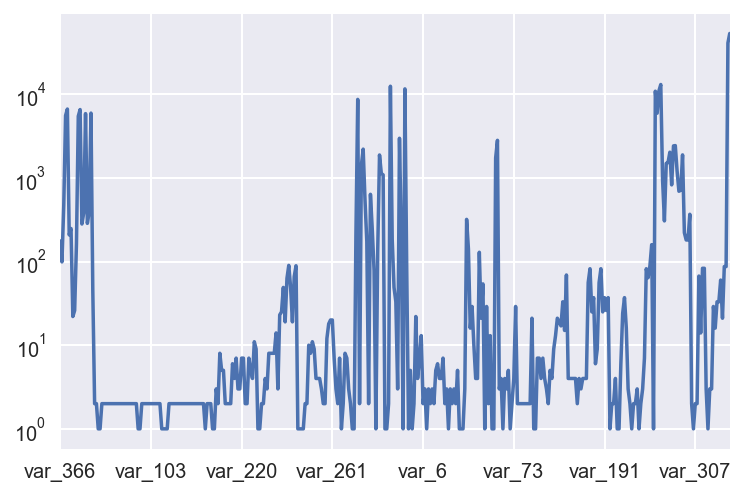

In [9]:
nuni_series.plot(logy=True);

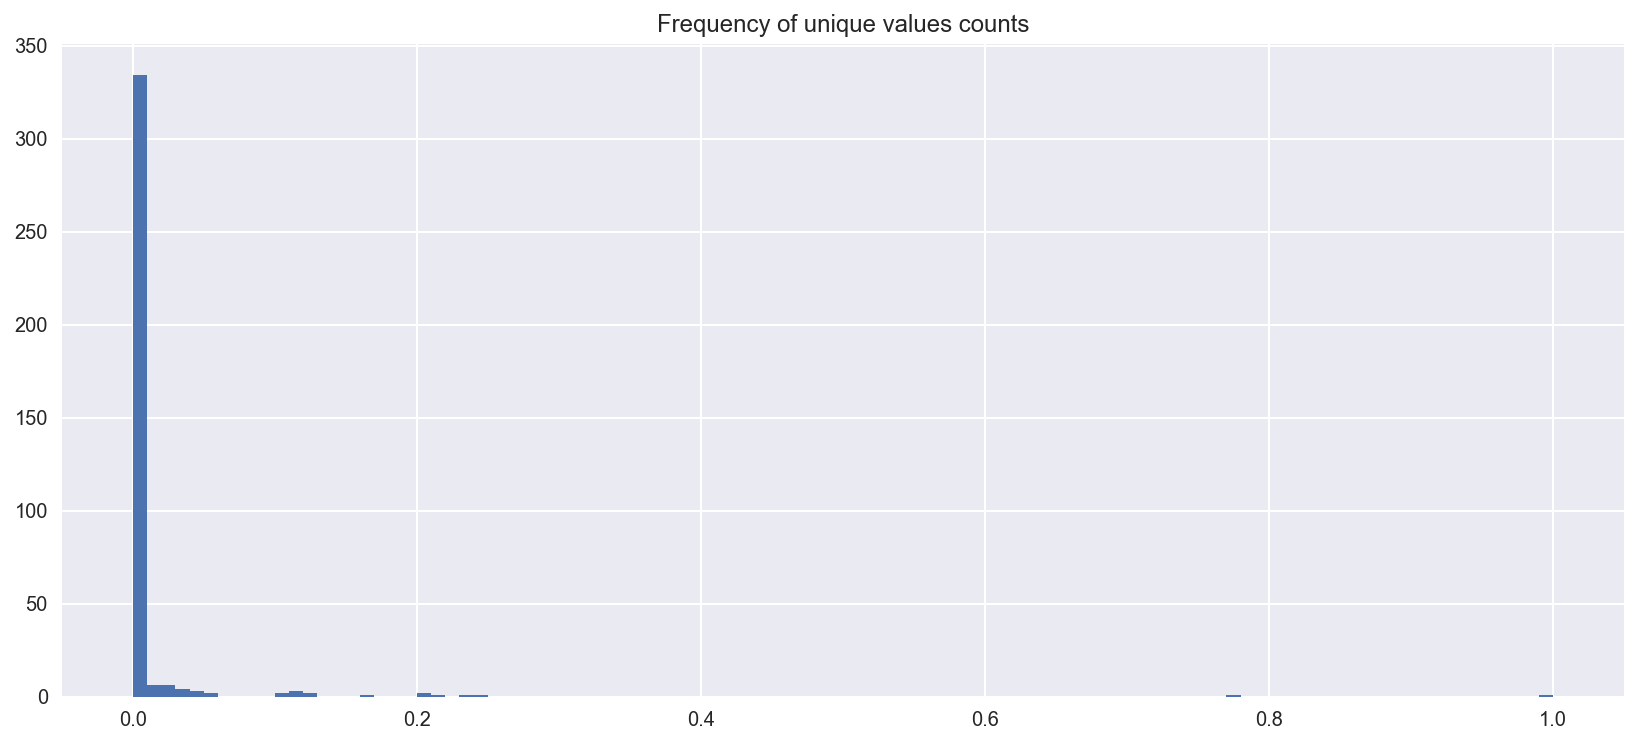

In [10]:
plt.figure(figsize=(14,6))
_ = plt.hist(nuni_series.astype(float)/X_train.shape[0], bins=100)
plt.title('Frequency of unique values counts');

There are quite a few features that have less than 10 unique values. On the other hand, there are also numeric features that have many unique values. Specially, the last column 'ID' has distinct values for each sample, which should be dropped.

## Separate numeric and categorical features

It's common to distinguish a categorical by its small counts of unique values. For this dataset, some outliers may "distort" the counts of some features. Thus, here I choose a relatively high threshold for value-counts, and consider the percentage of the 5 most frequent unique values of one feature, i.e.:
- count of unique values is less than 8;
- count of unique values is less than 30, and the 5 most unique values consist of more than 99.9% of all samples.

If one feature satisfies one of the two above condition, it will be treated as a categorical feature.

In [11]:
def get_topk_percent(data, k=5):
    '''
    get the percentage of the most k frequent unique values of one feature
    '''
    top = min(k, len(data))
    try:
        return data.value_counts(normalize=True).iloc[:top].sum()
    except:
        return np.nan

top5_percent = X_train.apply(get_topk_percent, k=5)

In [12]:
cat_conds = ((top5_percent>0.999) & (nuni_series <= 30)) | (nuni_series<=8) 

# categorical features
cat_feats = nuni_series[cat_conds].index.tolist()

# numeric features
num_feats = nuni_series[~cat_conds].index.tolist()

Numeric and categorical features are stored in `num_feats` and `cat_feats`, respectively.

In [13]:
print('# Numeric features:', len(num_feats))
print('# Categorical features:', len(cat_feats))

# Numeric features: 112
# Categorical features: 258


## Related features

It's necessary to detect correlated features, since we want to drop some duplicated columns to control the size of dataset.

In [14]:
corr_mat = X_train.corr().values

So I traverse all the columns, find these features which are highly correlated, and store them in a dictionary:

In [15]:
def get_dup_feats(thres):
    '''
    store cols whose correlation coef > thres into one item (list) of a dictionary
    '''
    dup_cols = {}
    cols_flag = np.zeros_like(X_train.columns)
    for i, c1 in enumerate(tqdm_notebook(X_train.columns)):
        if cols_flag[i] == 0:
            dup_cols[c1] = [c1]
            cols_flag[i] = 1
        for j, c2 in zip(range(i+1, X_train.shape[0]+1), X_train.columns[i+1:]):
            if cols_flag[j] == 0 and corr_mat[i, j] > thres:
                dup_cols[c1].append(c2)
                cols_flag[j] = 1
    return dup_cols

In [16]:
dup_feats_dic = get_dup_feats(0.95)
dup_feats_dic

{'var_366': ['var_366'],
 'var_364': ['var_364'],
 'var_38': ['var_38'],
 'var_39': ['var_39', 'var_49'],
 'var_40': ['var_40', 'var_50'],
 'var_44': ['var_44'],
 'var_45': ['var_45'],
 'var_46': ['var_46'],
 'var_47': ['var_47'],
 'var_48': ['var_48'],
 'var_51': ['var_51', 'var_41'],
 'var_52': ['var_52', 'var_42'],
 'var_53': ['var_53', 'var_43'],
 'var_60': ['var_60'],
 'var_95': ['var_95', 'var_131', 'var_229', 'var_268'],
 'var_75': ['var_75', 'var_130', 'var_128', 'var_212', 'var_267', 'var_264'],
 'var_113': ['var_113'],
 'var_96': ['var_96'],
 'var_141': ['var_141'],
 'var_140': ['var_140', 'var_283'],
 'var_143': ['var_143', 'var_112', 'var_286', 'var_247'],
 'var_142': ['var_142', 'var_111', 'var_285', 'var_246', 'var_362', 'var_348'],
 'var_147': ['var_147', 'var_290'],
 'var_146': ['var_146', 'var_289'],
 'var_79': ['var_79'],
 'var_78': ['var_78', 'var_213', 'var_161'],
 'var_81': ['var_81', 'var_80', 'var_216', 'var_215'],
 'var_83': ['var_83', 'var_82', 'var_218', 'var_

We take one group of correlated features and visualize their correlation coefficients:

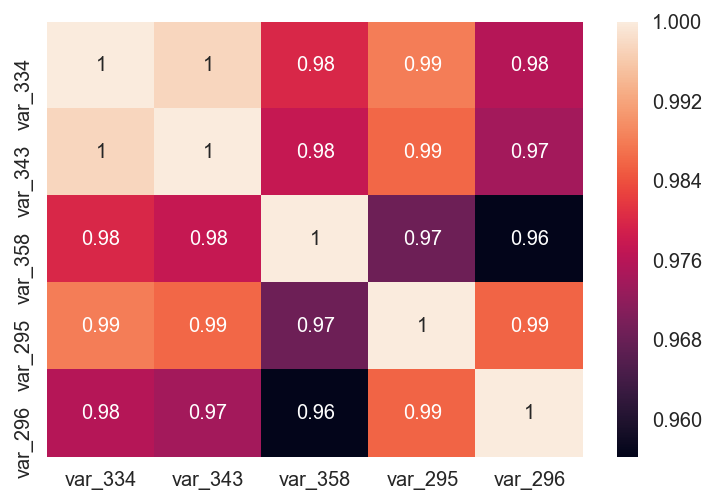

In [17]:
sns.heatmap(X_train[dup_feats_dic['var_334']].corr(), annot=True)

Indeed, they are highly correlated.

During our feature selection, we may only select one feature from each group.

# Preprocess the data

## Features Selection

According to the related features results, it's necessary to drop the duplicated features in the train set. Also, we need to deal with outliers for numeric and categorical features separately.

First, select one feature from each high-correlated group:

In [18]:
# select one feature from each high-correlated group
keep_cols = list(dup_feats_dic.keys())

Next, if a feature only has less than 10 sameples different from the most frequent value, then I treat it as a constant feature and drop it:

In [19]:
first_count = X_train[keep_cols].apply(lambda x:x.value_counts().iloc[0])
first_count.head()

var_366    51922
var_364    14154
var_38     50660
var_39     46229
var_40     44980
dtype: int64

In [20]:
const_cols = [x for x in first_count.index if first_count[x]>=X_train.shape[0]-10]

In [21]:
# 'ID' has distinct values in every row, which is useless
keep_cols = set(keep_cols) - set(const_cols) - {'ID'}
len(keep_cols)

177

Finally, we have 177 features remain in our train set. We divide them into numeric and categorical features for further conduction.

In [22]:
keep_num_feats = [x for x in keep_cols if x in num_feats]
keep_cat_feats = [x for x in keep_cols if x in cat_feats]
print('# remaining numeric features:', len(keep_num_feats))
print('# remaining categorical features:', len(keep_cat_feats))

# remaining numeric features: 80
# remaining categorical features: 97


In [23]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

## Pipeline for numerical features

Let's take a look at the boxplots of numeric features to detect outliers:

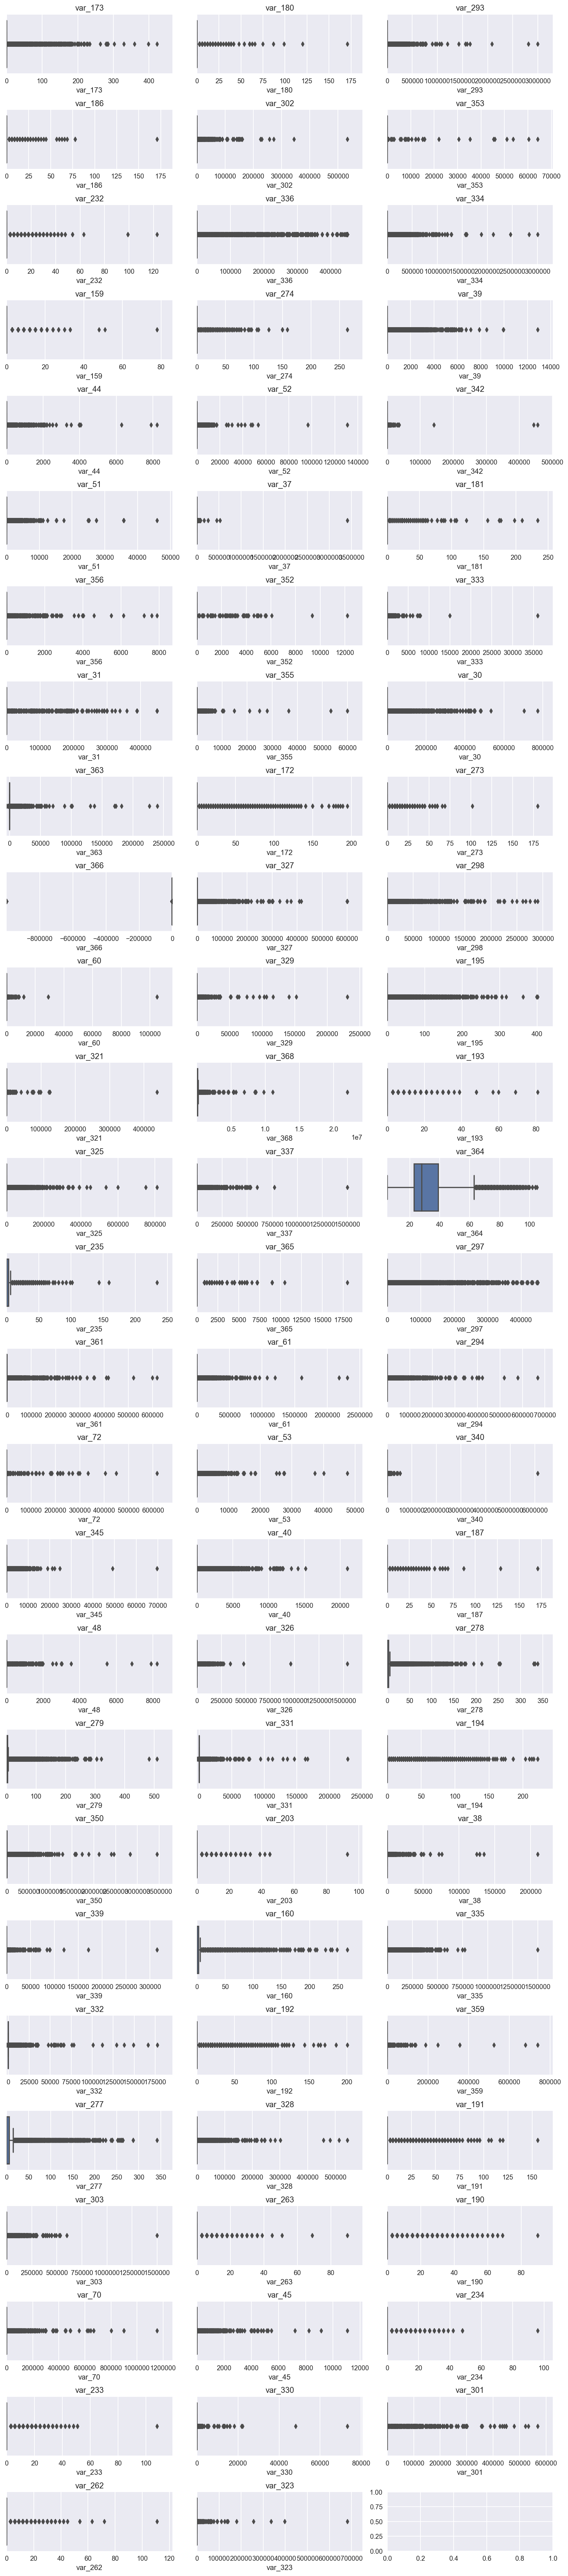

In [24]:
fig, axes = plt.subplots(nrows=27, ncols=3, figsize=(3*4, 27*2))
for i, feat in enumerate(tqdm_notebook(keep_num_feats)):
    sns.boxplot(x=X_train[feat], ax=axes.flatten()[i])
    ax=axes.flatten()[i]
    ax.set_xlim(X_train[feat].min(), X_train[feat].max()*1.1)
    ax.set_title(feat)
plt.tight_layout()

There are a lot of outliers in these features. I consider clip them within $median\pm n\times std$, and examine the boxplots again:

In [25]:
train = X_train.copy()

train[keep_num_feats] = train[keep_num_feats].apply(lambda x:x.clip(x.median()-5*x.std(),
                                                                       x.median()+5*x.std()))

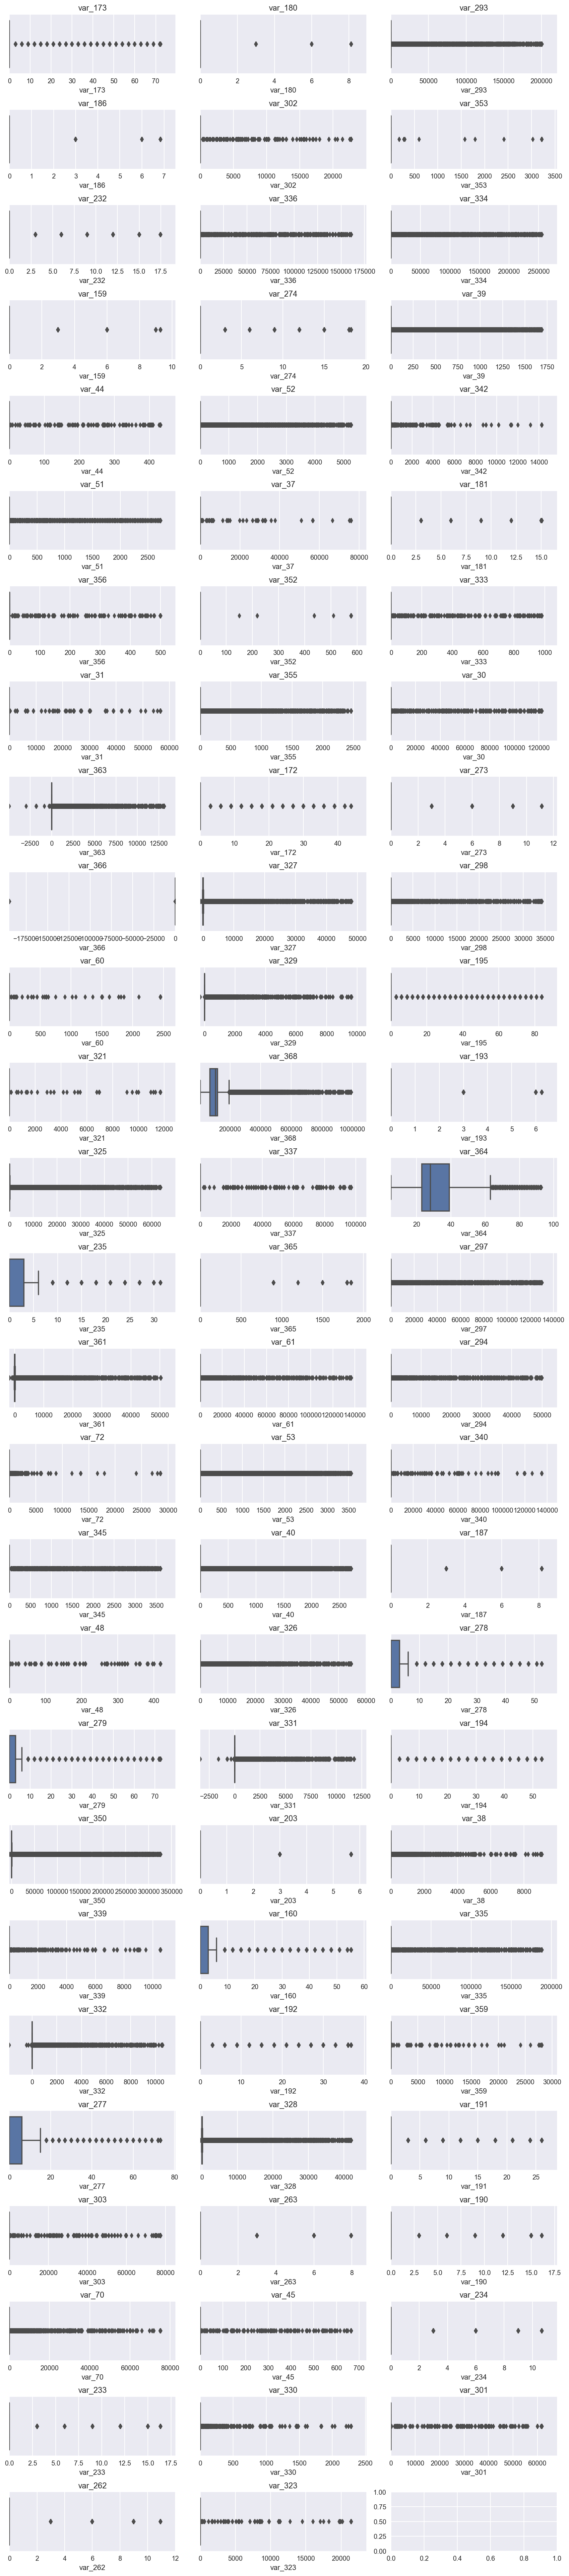

In [26]:
fig, axes = plt.subplots(nrows=27, ncols=3, figsize=(3*4, 27*2))
for i, feat in enumerate(tqdm_notebook(keep_num_feats)):
    sns.boxplot(x=train[feat], ax=axes.flatten()[i])
    ax=axes.flatten()[i]
    ax.set_xlim(train[feat].min(), train[feat].max()*1.1)
    ax.set_title(feat)
plt.tight_layout()

It looks much better except `var_3666`. Indeed, there are many `-999999` in this feature, wich may represent missing values. Hence, I will deal with this feature manally.

In [27]:
class OutlierProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, n_std):
        self.n_std = n_std

    def fit(self, X, y=None):
        self.upper_border = (X.median() + self.n_std*X.std()).values
        self.lower_border = (X.median() - self.n_std*X.std()).values
        return self

    def transform(self, X):
        X = X.clip(self.lower_border, self.upper_border, axis=1)
        # deal with var_366 manually
        X.loc[X['var_366'] == -999999, 'var_366'] = 0
        return X

In [28]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(keep_num_feats)),
        ('outlier_proc', OutlierProcessor(5)),
        ('std_scaler', StandardScaler()),
    ])


## Pipeline for categorical features

There could also be many outliers in categorical features. Therefore, for values that appear less than twice in a feature, I set it to `-999`:

In [29]:
class OutlierTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        keep_dict = {}
        for feat in keep_cat_feats:
            count = X[feat].value_counts()
            keep_values = count[count>2].index.tolist()
            keep_dict[feat] = keep_values
        self.dict = keep_dict
        return self

    def transform(self, X):
        for feat in tqdm_notebook(keep_cat_feats):
            if list(X[feat].unique()) != self.dict[feat]:
                X.loc[~X[feat].isin(self.dict[feat]),feat] = -999
        return X.values

In [30]:
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(keep_cat_feats)),
        ('outlier_trans', OutlierTransformer()),
        ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore')),
    ])

In [31]:
# cat_pipeline = Pipeline([
#         ('selector', DataFrameSelector(keep_cat_feats)),
#         ('outlier_trans', OutlierTransformer()),
#         ('onehot', OneHotEncoder(categories='auto', sparse=False, drop='first')),
#     ])

In [32]:
full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [33]:
train_data = full_pipeline.fit_transform(X_train)

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


# Fit a few classification models

## L2 penalty

Since this dataset is imbalanced, I give a samples with label 1 a higher weight:

In [60]:
cv = StratifiedKFold(5, random_state=1)
gs = GridSearchCV(SGDClassifier(loss='log', random_state=1,class_weight={0:1,1:5}), cv=cv,
                  param_grid={"alpha": np.logspace(-6, -1, 10)}, scoring='f1', verbose=2, n_jobs=-1)

In [61]:
gs.fit(train_data, Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   59.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=False),
             error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight={0: 1, 1: 5},
                                     early_stopping=False, epsilon=0.1,
                                     eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='log', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', pow...
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-06, 3.59381366e-06, 1.29154967e-05, 4.64158883e-05,
       1

In [62]:
gs.cv_results_

{'mean_fit_time': array([14.73346229, 15.52762823, 13.75996552, 12.87437267,  9.94181809,
         6.90074878,  5.10827174,  3.37178369,  2.92338295,  2.18716311]),
 'std_fit_time': array([4.10653649, 4.33228122, 2.88986023, 3.09488046, 1.19613802,
        0.49789794, 0.44787958, 0.27172471, 0.21548664, 0.3503188 ]),
 'mean_score_time': array([0.04148788, 0.04089041, 0.03989205, 0.03211379, 0.03331051,
        0.04428039, 0.0476737 , 0.05525155, 0.04148965, 0.01993308]),
 'std_score_time': array([0.00343167, 0.00819985, 0.01309578, 0.00263096, 0.00677889,
        0.00510855, 0.00835417, 0.01113409, 0.00884285, 0.00633905]),
 'param_alpha': masked_array(data=[1e-06, 3.5938136638046257e-06, 1.2915496650148827e-05,
                    4.641588833612782e-05, 0.0001668100537200059,
                    0.0005994842503189409, 0.0021544346900318843,
                    0.007742636826811277, 0.02782559402207126, 0.1],
              mask=[False, False, False, False, False, False, False, False,
 

In [63]:
model_l2 = gs.best_estimator_
model_l2.get_params()['alpha']

0.0021544346900318843

The optimal alpha for L2 penalty is about 2e-3.

In [64]:
Y_train_pred = model_l2.predict(train_data)
Y_train_pred_proba = model_l2.predict_proba(train_data)[:,1]
print('F1 score:',f1_score(Y_train, Y_train_pred))
print('Log loss:',log_loss(Y_train, Y_train_pred))
print('AUC:',roc_auc_score(Y_train, Y_train_pred_proba))

F1 score: 0.16873187450566834
Log loss: 2.0464889957080294
AUC: 0.8113408560204439


In [65]:
optimal_l2 = Pipeline([
        ("preparation", full_pipeline),
        ("l2", model_l2)
    ])
joblib.dump(optimal_l2, 'optimal_l2.pkl')

['optimal_l2.pkl']

## L1 penalty

In [34]:
cv = StratifiedKFold(5, random_state=1)
gs = GridSearchCV(SGDClassifier(loss='log', penalty='l1', random_state=1, class_weight={0:1,1:5}), cv=cv,
                  param_grid={"alpha": np.logspace(-6, -1, 10)}, scoring='f1', verbose=2, n_jobs=-1)

In [35]:
gs.fit(train_data, Y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.0min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=False),
             error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight={0: 1, 1: 5},
                                     early_stopping=False, epsilon=0.1,
                                     eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='log', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l1', pow...
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-06, 3.59381366e-06, 1.29154967e-05, 4.64158883e-05,
       1

In [36]:
model_l1 = gs.best_estimator_
model_l1.get_params()['alpha']

0.0005994842503189409

The optimal alpha for L1 penaly is about 6e-4.

In [37]:
Y_train_pred = model_l1.predict(train_data)
Y_train_pred_proba = model_l1.predict_proba(train_data)[:,1]
print('F1 score:',f1_score(Y_train, Y_train_pred))
print('Log loss:',log_loss(Y_train, Y_train_pred))
print('AUC:',roc_auc_score(Y_train, Y_train_pred_proba))

F1 score: 0.17877347816248018
Log loss: 2.3554471296983612
AUC: 0.8055904864257256


In [38]:
optimal_l1 = Pipeline([
        ("preparation", full_pipeline),
        ("l1", model_l1)
    ])
joblib.dump(optimal_l1, 'optimal_l1.pkl')

['optimal_l1.pkl']

## Elasticnet

In [39]:
cv = StratifiedKFold(5, random_state=1)
gs = GridSearchCV(SGDClassifier(loss='log', penalty='elasticnet',random_state=1,
                                class_weight={0:1,1:5}), cv=cv,
                  param_grid={
                      "alpha": np.logspace(-6, -1, 5),
                      "l1_ratio": np.logspace(-6, -1, 5)
                  }, scoring='f1', verbose=2, n_jobs=-1)

In [40]:
gs.fit(train_data, Y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  3.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=False),
             error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight={0: 1, 1: 5},
                                     early_stopping=False, epsilon=0.1,
                                     eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='log', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='elastic...
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-06, 1.77827941e-05, 3.16227766e-04, 5.62341325e-03,
       1.00000000e-01]),
                         'l1_ratio': array([1.

In [41]:
model_ela = gs.best_estimator_
print(model_ela.get_params()['alpha'])
print(model_ela.get_params()['l1_ratio'])

0.005623413251903491
1e-06


The optimal alpha and l1_ratio for elasticnet is about 6e-3, 1e-6.

In [42]:
Y_train_pred = model_ela.predict(train_data)
Y_train_pred_proba = model_ela.predict_proba(train_data)[:,1]
print('F1 score:',f1_score(Y_train, Y_train_pred))
print('Log loss:',log_loss(Y_train, Y_train_pred))
print('AUC:',roc_auc_score(Y_train, Y_train_pred_proba))

F1 score: 0.16844919786096257
Log loss: 2.0185789388497253
AUC: 0.8062458458241524


In [43]:
optimal_ela = Pipeline([
        ("preparation", full_pipeline),
        ("elasticnet", model_ela)
    ])
joblib.dump(optimal_ela, 'optimal_elasticnet.pkl')

['optimal_elasticnet.pkl']

F1 score may not be an appropriate metric, since it's sensitive to # predicted positive samples and random seeds.

## ROC/PR curve

### ROC Curve

In [66]:
def plot_roc_curve(X, Y, model_list, name_list):
    fig, ax = plt.subplots()
    ax.plot([0, 1], [0, 1], 'k--')
    if not isinstance(model_list, list):
        model_list = [model_list]
    if not isinstance(name_list, list):
        name_list = [name_list]   
    for model, name in zip(model_list, name_list):
        Y_pred = model.predict(X)
        Y_pred_proba = model.predict_proba(X)[:,1]
        fpr_, tpr_, thresholds_ = roc_curve(Y, Y_pred_proba)
        auc_ = auc(fpr_, tpr_)

        # plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
        ax.plot(fpr_, tpr_, label=name+' (area = {:.3f})'.format(auc_))

    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')
    ax.set_title('ROC Curve')
    ax.legend(loc='best')

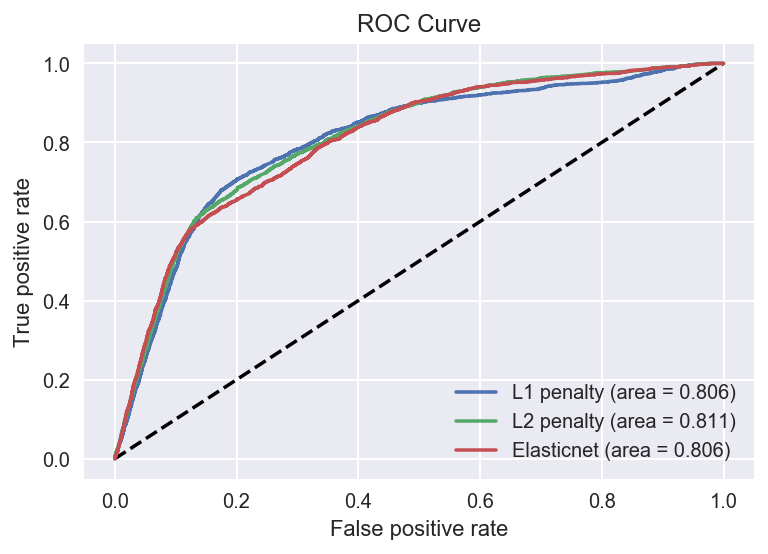

In [67]:
plot_roc_curve(train_data, Y_train, [model_l1, model_l2, model_ela],
               ['L1 penalty', 'L2 penalty', 'Elasticnet'])

### Precision-Recall Curve

In [68]:
def plot_pr_curve(X, Y, model_list, name_list):
    fig, ax = plt.subplots()
    if not isinstance(model_list, list):
        model_list = [model_list]
    if not isinstance(name_list, list):
        name_list = [name_list]   
    for model, name in zip(model_list, name_list):
        Y_pred = model.predict(X)
        Y_pred_proba = model.predict_proba(X)[:,1]
        precision, recall, _ = precision_recall_curve(Y, Y_pred_proba)
        
        # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
        # step_kwargs = ({'step': 'post'}
        #                if 'step' in signature(plt.fill_between).parameters
        #                else {})
        # plt.step(recall, precision, color='b', alpha=0.2,
        #          where='post')
        ax.fill_between(recall, precision, alpha=0.5, label=name)

        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_ylim([0.0, 1.05])
        ax.set_xlim([0.0, 1.0])
        ax.legend(loc='best')
    ax.set_title('Precision-Recall Curve')
# plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
#           average_precision))

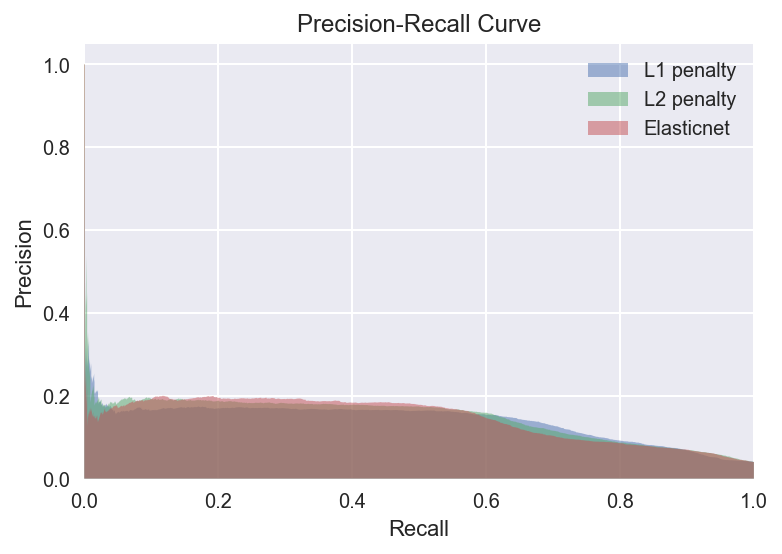

In [69]:
plot_pr_curve(train_data, Y_train, [model_l1, model_l2, model_ela],
               ['L1 penalty', 'L2 penalty', 'Elasticnet'])

## Optimal vs Suboptimal

I choose the L2 penalty model to compare the models with the optimal and suboptimal parameters:

In [70]:
model_l2_sub = SGDClassifier(loss='log', random_state=1,
                             alpha=0.0001668100537200059, class_weight={0:1,1:5})
model_l2_sub.fit(train_data, Y_train)

SGDClassifier(alpha=0.0001668100537200059, average=False,
              class_weight={0: 1, 1: 5}, early_stopping=False, epsilon=0.1,
              eta0=0.0, fit_intercept=True, l1_ratio=0.15,
              learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=1, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

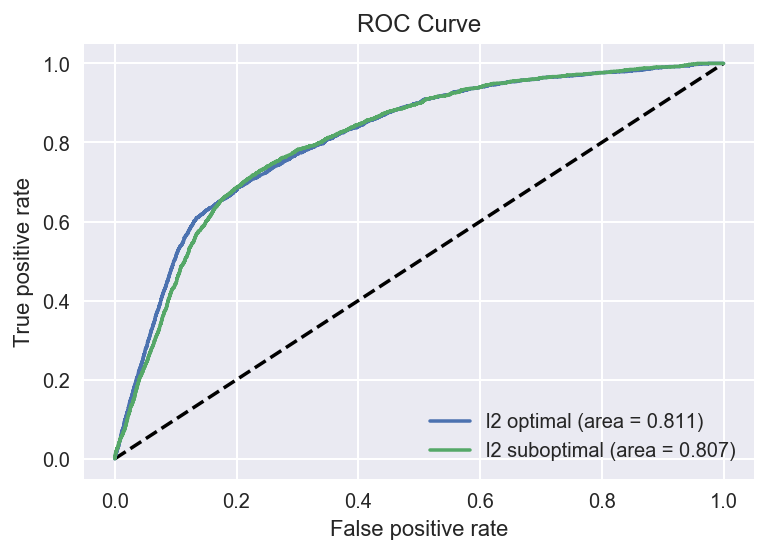

In [71]:
plot_roc_curve(train_data, Y_train, [model_l2, model_l2_sub], ['l2 optimal', 'l2 suboptimal'])

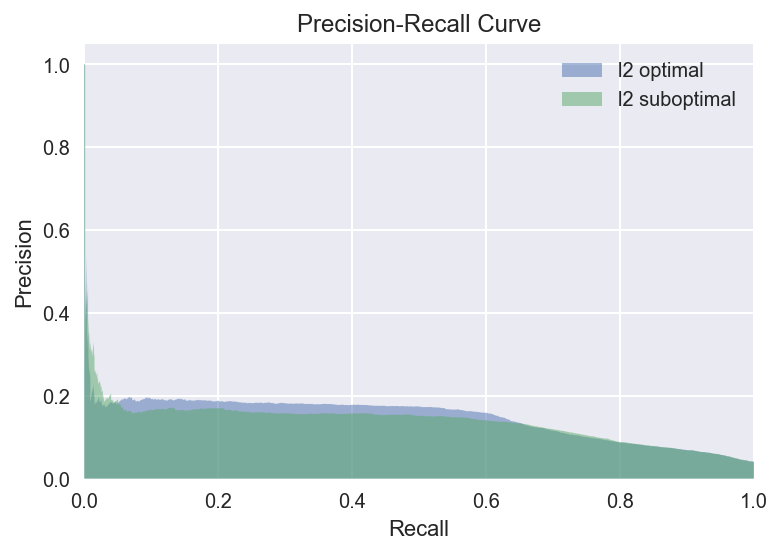

In [72]:
plot_pr_curve(train_data, Y_train, [model_l2, model_l2_sub], ['l2 optimal', 'l2 suboptimal'])

It seems that the optimal model is slightly better than the suboptimal model. Actually, the optimal parameters just optimize F1 score, which may not have too much effects on ROC/PR curve.

# Other scikit-learn classification models

I will use a model from `LightGBM`, which is wrapped in a sklearn API.

In [86]:
from lightgbm import LGBMClassifier

param_grid = {
    'max_depth': [4, 5, 6, 7],
    'learning_rate': [0.05, 0.1, 0.2],
}

cv = StratifiedKFold(5, random_state=1)
gs_lgb = GridSearchCV(LGBMClassifier(objective='binary', class_weight={0: 1, 1: 5}, random_state=1), cv=cv,
                      param_grid=param_grid, scoring='f1', verbose=2, n_jobs=-1)

In [87]:
gs_lgb.fit(train_data, Y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   41.7s
D:\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.4min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=False),
             error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt',
                                      class_weight={0: 1, 1: 5},
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31,
                                      objective='binary', random_state=1,
                                      reg_alpha=0.0, reg_lambda=0.0,
                                      silent=True, subsample=1.0,
                                      subsample_for_bin=200000,
                        

In [88]:
model_lgb = gs_lgb.best_estimator_

In [89]:
Y_train_pred = model_lgb.predict(train_data)
Y_train_pred_proba = model_lgb.predict_proba(train_data)[:,1]
print('F1 score:',f1_score(Y_train, Y_train_pred))
print('Log loss:',log_loss(Y_train, Y_train_pred))
print('AUC:',roc_auc_score(Y_train, Y_train_pred_proba))

F1 score: 0.3402742508887761
Log loss: 2.5294068793954296
AUC: 0.8988999783011092


This model has a F1 score = 0.340 on the train set.

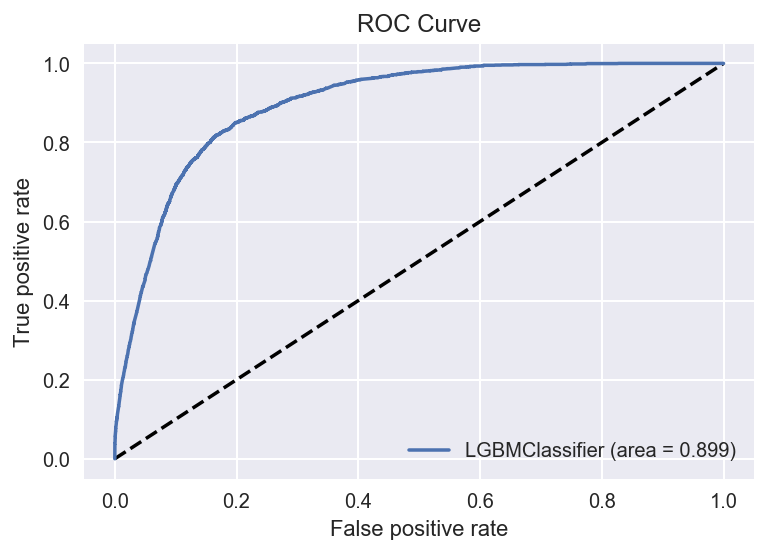

In [90]:
plot_roc_curve(train_data, Y_train, model_lgb, 'LGBMClassifier')

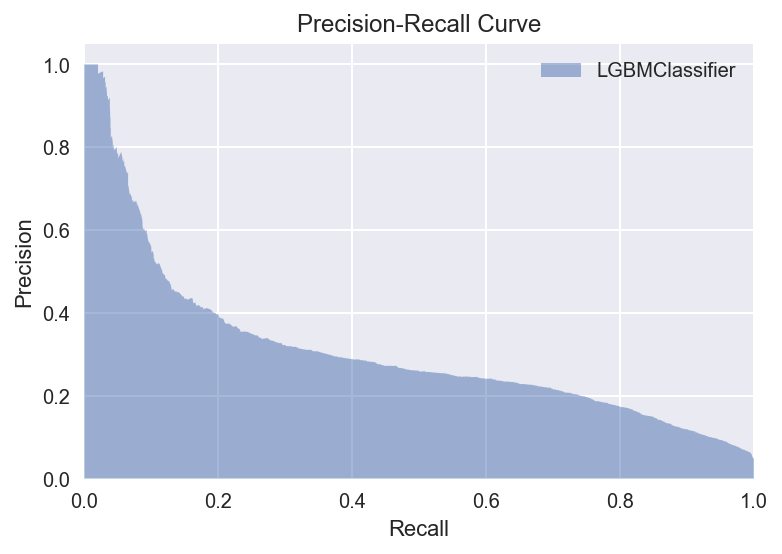

In [91]:
plot_pr_curve(train_data, Y_train, model_lgb, 'LGBMClassifier')

# Use the test set

In [92]:
test_data = full_pipeline.transform(X_test)

def get_test_f1(model, X=test_data, Y=Y_test):
    Y_pred = model.predict(X)
    return f1_score(Y, Y_pred)

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [93]:
print('L1 penalty model F1 score:', get_test_f1(model_l1))
print('L2 penalty model F1 score:', get_test_f1(model_l2))
print('Elasticnet model F1 score:', get_test_f1(model_ela))
print('LightGBM model F1 score:', get_test_f1(model_lgb))

L1 penalty model F1 score: 0.17595002602811036
L2 penalty model F1 score: 0.15985356924954242
Elasticnet model F1 score: 0.16822429906542055
LightGBM model F1 score: 0.270096463022508


My best model is the LightGBM model, whose F1 score on the test set is 0.270.

In [94]:
best_model = Pipeline([
        ("preparation", full_pipeline),
        ("lgbm", model_lgb)
    ])
joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']